# Generate a Audit Trail test file
## Define program variable

In [100]:
#Define User Variable
import ipywidgets as widgets
import pandas as pd


temp = pd.read_excel('AuditTrailDataEntries.xlsx', None)

dataBaseEntries = {
    'Setup': pd.DataFrame( columns = ['Start Date', 'End Date', 'Max Audit Trail entries', 'Filename']),
    'UserDefault': pd.DataFrame( columns = ['User ID', 'Probability'] ),
    'User': pd.DataFrame( columns = ['User ID', 'Probability'] ),
    'Description': pd.DataFrame( columns = ['User ID', 'Object ID','Description', 'Probability'] ),
    'Comments':  pd.DataFrame( columns = ['User ID', 'Description', 'Comment', 'Probability'] ),
    'Variable': pd.DataFrame( columns = ['Name', 'min', 'max', 'step', 'Probability'] )
}

dataBase = pd.DataFrame(columns = ['Timestamp', 'User ID', 'Object ID', 'Description', 'Comments'])

In [101]:
if dataBaseEntries['Setup'].empty:
    dataBaseEntries['Setup'].loc[1,'Start Date'] = '01.05.2020 6:00:00'
    dataBaseEntries['Setup'].loc[1,'End Date'] = '01.05.2020 15:00:00'
    dataBaseEntries['Setup'].loc[1,'Max Audit Trail entries'] = 100
    dataBaseEntries['Setup'].loc[1,'Filename'] = 'AuditTrail.csv'

dataBaseEntries['Setup']

,Start Date,End Date,Max Audit Trail entries,Filename
1,01.05.2020 6:00:00,01.05.2020 15:00:00,100,AuditTrail.csv


## 1. Generate **default users** entries (if needed)
    dataBaseEntries['UserDefault']

In [102]:
#Define default users
entries = {
    'Admin': 0.2,
    'System': 0.1,
    'User': 0.7
}

if dataBaseEntries['UserDefault'].empty:
    dataBaseEntries['UserDefault']['User ID'] = entries.keys()
    dataBaseEntries['UserDefault']['Probability'] = entries.values()

#dataBaseEntries['UserDefault']

In [103]:
#userDB.loc['Admin']

#userDB.loc[lambda userDB: userDB['User ID'] == 'Admin', :]
#db = dataBaseEntries['UserDefault']
#db.loc[ lambda db: db['User ID'] == 'template', :]


## 2. Generate **real users** entries (if needed)
    dataBaseEntries['User']

In [104]:
#Define Users
from IPython.display import display, HTML

entriesUser = [
    'pharma/de01234',
    'pharma/I047874',
    'pharma/I984321'
]

userDb = dataBaseEntries['User']


if userDb.empty:
    
    userDefaultDb = dataBaseEntries['UserDefault']
    
    user = userDefaultDb.loc[ lambda userDefaultDb: userDefaultDb['User ID'] == 'User', :]
    
    if not user.empty:
        size = len(entriesUser)
        value = user['Probability'].values[0]/size
            
        userDb['User ID'] = entriesUser
        userDb['Probability'] = [value]*(size)#equal porp for all users

#display(dataBaseEntries['User'])


In [105]:
# Output
import ipywidgets as widgets

h1 = dataBaseEntries['UserDefault'].to_html()
h2 = dataBaseEntries['User'].to_html()
L1 = widgets.Label('User Group')
L2 = widgets.Label('User')
b1 = widgets.VBox([L1,widgets.HTML(h1)])
b2 = widgets.VBox([L2,widgets.HTML(h2)])
widgets.HBox([b1,b2])

## 3. Generate **description** entries (if needed)
> dataBaseEntries['Description']
    
For each user role several descriptions will be provieded
1. Admin
2. System
3. User 

In [106]:
#helping method
def generateLists(userID, descriptions):
    
    userList = []
    objectIdList = []
    descriptionList = []
    propList = []
    
    for key, value in descriptions.items():
        userList = [userID] * len(descriptions) * len(value)
        objectIdList = [key] * len(value)
        descriptionList = list(value.keys())
        propList = list(value.values())
    
    return [userList, objectIdList, descriptionList, propList]

### 3.1. Admin description

In [107]:
adminLists = [[]]

if dataBaseEntries['Description'].empty or 'Admin' not in dataBaseEntries['Description']['User ID'].values:
    adminDescriptions = {
        'Anwendung': {
            'Wechsel in die Betriebsart Online' : 0.2,
            'Wechsel in die Betriebsart Offline' : 0.2,
            'Anwendung wird gestartet' : 0.2,
            'Anwendung wird beendet' : 0.4
        }
    }
    adminLists = generateLists('Admin', adminDescriptions)

### 3.2. System description

In [108]:
systemLists = [[]]

if dataBaseEntries['Description'].empty or 'System' not in dataBaseEntries['Description']['User ID'].values:
    systemDescriptions = {
        'Benutzerverwaltung': {
            'Benutzer # wurde hinzugefügt' : 0.1,
            'Benutzer # wurde entfernt' : 0.1,
            'Benutzer # ist keiner Gruppe zugeordnet' : 0.4,
            'Benutzer # ist einer neuen Gruppe zugeordnet' : 0.4,
        }
    }
    systemLists = generateLists('System', systemDescriptions)

### 3.3. User description
#### 3.3.1. Generate static user descriptions

In [109]:
userLists = [[]]

if dataBaseEntries['Description'].empty or 'User' not in dataBaseEntries['Description']['User ID'].values:
    userDescriptions = {
        'Variable': {
            'Wert wurde gelöscht' : 0.1,
            'Hambeuldu' : 0.1
        }
    } 
    userLists = generateLists('User', userDescriptions)

#### 3.3.2. Generate dynamic user descriptions

The descriptions for the role ***User*** will be generated *random dynamic* with the entries from <br>
   
>dataBaseEntries['Variable']

In [110]:
#add variable names
#add variable value ranges
#generate entries for userList or enhance dataBase Entries


if dataBaseEntries['Variable'].empty:
    varEntries = {
        'Schwellwert': [[0, 255, 1], 0.1],
        'Umfang': [[32, 600, 5], 0.1],
        'Verstärkung': [[0, 300, 1], 0.1],
        'Mirror': [[0, 1, 1], 0.1],
        'Position': [[10000, 20000, 20], 0.1],
        'Länge': [[-10, 100, 1], 0.1],
        'Breite': [[-20, 100, 1], 0.1],
        'Geschwindigkeit': [[1, 500, 1], 0.1],
        'Gewicht': [[0.01, 100, 0.1], 0.1],
        'Dauer': [[10, 1000, 10], 0.1]      
    }
    
    nameList = []
    minList = []
    maxList = []
    stepList = []
    propList = []
    
    for key, value in varEntries.items():
        nameList.append(key)
        minList.append(value[0][0])
        maxList.append(value[0][1])
        stepList.append(value[0][2])
        propList.append(value[1])

    dataBaseEntries['Variable']['Name'] = nameList
    dataBaseEntries['Variable']['min'] = minList
    dataBaseEntries['Variable']['max'] = maxList
    dataBaseEntries['Variable']['step'] = stepList
    dataBaseEntries['Variable']['Probability'] = propList
    
    display(dataBaseEntries['Variable'])

,Name,min,max,step,Probability
0,Schwellwert,0.00,255,1.0,0.1
1,Umfang,32.00,600,5.0,0.1
2,Verstärkung,0.00,300,1.0,0.1
3,Mirror,0.00,1,1.0,0.1
4,Position,10000.00,20000,20.0,0.1
5,Länge,-10.00,100,1.0,0.1
6,Breite,-20.00,100,1.0,0.1
7,Geschwindigkeit,1.00,500,1.0,0.1
8,Gewicht,0.01,100,0.1,0.1
9,Dauer,10.00,1000,10.0,0.1


#### 3.3.2.1 Generate random entries

In [111]:
import numpy as np # import random insteed

nVarEntries = dataBaseEntries['Setup'].loc[1, 'Max Audit Trail entries']
variableDb = dataBaseEntries['Variable']
varEntries = np.random.choice(variableDb['Name'].to_list(), nVarEntries)

userLists[0] += ['User']*nVarEntries
userLists[1] += ['Variable']*nVarEntries

for entry in varEntries:
    row = variableDb.loc[variableDb['Name'] == entry]
    collection = np.arange(row['min'].iloc[0],row['max'].iloc[0],row['step'].iloc[0])
    mm = np.random.choice(collection,2)
    text = f'Variable {entry} is changed from {mm[0]} to {mm[1]}'
    userLists[2].append( text )
    userLists[3].append( row['Probability'].iloc[0] )

## Add the lists to the data base

In [112]:
masterList = [[],[],[],[]]

if adminLists:
    masterList[0] += adminLists[0]
    masterList[1] += adminLists[1]
    masterList[2] += adminLists[2]
    #normelize values
    masterList[3] += [float(i)/sum(adminLists[3]) for i in adminLists[3]] 
    
if systemLists:
    masterList[0] += systemLists[0]
    masterList[1] += systemLists[1]
    masterList[2] += systemLists[2]
    #normelize values
    masterList[3] += [float(i)/sum(systemLists[3]) for i in systemLists[3]] 
if userLists:
    masterList[0] += userLists[0]
    masterList[1] += userLists[1]
    masterList[2] += userLists[2]
    #normelize values
    masterList[3] += [float(i)/sum(userLists[3]) for i in userLists[3]] 

    
dataBaseEntries['Description']['User ID'] = masterList[0]
dataBaseEntries['Description']['Object ID'] = masterList[1]
dataBaseEntries['Description']['Description'] = masterList[2]
dataBaseEntries['Description']['Probability'] = masterList[3]

dataBaseEntries['Description']

,User ID,Object ID,Description,Probability
0,Admin,Anwendung,Wechsel in die Betriebsart Online,0.200000
1,Admin,Anwendung,Wechsel in die Betriebsart Offline,0.200000
2,Admin,Anwendung,Anwendung wird gestartet,0.200000
3,Admin,Anwendung,Anwendung wird beendet,0.400000
4,System,Benutzerverwaltung,Benutzer # wurde hinzugefügt,0.100000
...,...,...,...,...
105,User,Variable,Variable Verstärkung is changed from 7.0 to 100.0,0.009804
106,User,Variable,Variable Verstärkung is changed from 263.0 to ...,0.009804
107,User,Variable,Variable Dauer is changed from 80.0 to 430.0,0.009804
108,User,Variable,Variable Geschwindigkeit is changed from 308.0...,0.009804


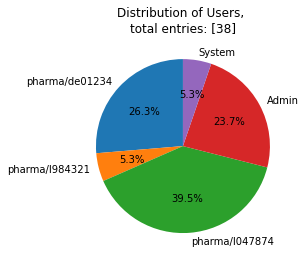

In [113]:
#Generate random values
#1. numbers of audit trail entries
import collections
import matplotlib.pyplot as plt

#userDB = dataBaseEntries['User']

userDB = pd.concat( 
    [dataBaseEntries['User'], userDefaultDb.loc[ lambda userDefaultDb: userDefaultDb['User ID'] != 'User', :]], 
    ignore_index = True )


nOfAtEntries = np.random.choice(dataBaseEntries['Setup']['Max Audit Trail entries'].iloc[0], 1)
#userEntries = np.random.choice(userIDs, nOfAtEntries, p=userProp)
userEntries = np.random.choice(userDB['User ID'].to_list(), nOfAtEntries, p=userDB['Probability'].to_list())
#plot the distribution of users
plotValues = collections.Counter(userEntries)

plt.pie(list(plotValues.values()), labels=list(plotValues.keys()), startangle=90, autopct='%.1f%%' )
plt.title(f'Distribution of Users, \ntotal entries: {nOfAtEntries}')

plt.show()

In [114]:
#3. enhance database entries
userList = []
objectList = []
descriptionList = []
commentsList = []

In [115]:
#User login and logof entries
logIn = 'An'
logOff = 'Ab'

logEntryDic = {
    'UserId': dataBaseEntries['UserDefault']['User ID'][1], 
    'ObjectId': 'Benutzerverwaltung',
    'Description': 'meldung von Benutzer # war erfolgreich.' 
}

In [116]:
#helping functions
import re #regex 

def logEntry(logPostFix, user):
    userList.append(logEntryDic['UserId'])
    descriptionList.append(logPostFix + re.sub('#', user, logEntryDic['Description']))
    objectList.append(logEntryDic['ObjectId'])
    
def userEntry(user):
    userList.append(user)
    
    #1 getDataFrame Description
    db = dataBaseEntries['Description']
    
    #2 get Description 
    #2.1 get user group
    sUser = user
    if sUser not in dataBaseEntries['UserDefault']['User ID'].to_list():
        sUser = 'User'
    
    #2.2 get Description related to user
    selection = db.loc[ lambda db: db['User ID'] == sUser, :]
    
    #3 get random user action
    ds = np.random.choice(selection['Description'], 1, p=selection['Probability'])                          
        
    descriptionList.append(ds[0])# random user related description ID
    
    #4 get related object id to the description 
    row = selection.loc[selection['Description'] == ds[0]]
    objectList.append( row['Object ID'].iloc[0] )#random user related object ID
    
    #5 get related comment     

In [117]:
#3. enhance database entries
loggedUser = None
newUser = None

for user in userEntries:
    if user not in dataBaseEntries['User'].values:
        if loggedUser:
            logEntry(logOff, loggedUser)
            loggedUser = None
        userEntry(user)
    
    if user in dataBaseEntries['User'].values:
        newUser = user      
        while newUser:
            if not loggedUser:
                loggedUser = user
                logEntry(logIn, user) 
            if loggedUser == user:
                userEntry(user)
                newUser = None
            else:
                logEntry(logOff, loggedUser)
                loggedUser = None
                newUser = user
            
if loggedUser:
    logEntry(logOff, user)
    loggedUser = None

In [118]:
#2. Random timestamps for each entry
atStartDate = dataBaseEntries['Setup'].loc[1, 'Start Date']
atEndDate = dataBaseEntries['Setup'].loc[1, 'End Date']

entries = np.random.choice( pd.date_range( atStartDate, atEndDate, freq='S'), 
                           len(userList), 
                           replace=False)

In [119]:
dataBase['Timestamp'] = pd.to_datetime(np.sort(entries))
dataBase['User ID'] = userList
dataBase['Object ID'] = objectList
dataBase['Description'] = descriptionList

dataBase

,Timestamp,User ID,Object ID,Description,Comments
0,2020-01-05 06:03:03,System,Benutzerverwaltung,Anmeldung von Benutzer pharma/de01234 war erfo...,NaN
1,2020-01-05 06:03:16,pharma/de01234,Variable,Variable Dauer is changed from 500.0 to 650.0,NaN
2,2020-01-05 06:05:14,System,Benutzerverwaltung,Abmeldung von Benutzer pharma/de01234 war erfo...,NaN
3,2020-01-05 06:24:45,System,Benutzerverwaltung,Anmeldung von Benutzer pharma/I984321 war erfo...,NaN
4,2020-01-05 06:39:18,pharma/I984321,Variable,Variable Geschwindigkeit is changed from 18.0 ...,NaN
...,...,...,...,...,...
67,2020-01-05 14:35:24,pharma/de01234,Variable,Variable Mirror is changed from 0.0 to 0.0,NaN
68,2020-01-05 14:39:49,System,Benutzerverwaltung,Abmeldung von Benutzer pharma/de01234 war erfo...,NaN
69,2020-01-05 14:39:50,System,Benutzerverwaltung,Anmeldung von Benutzer pharma/I984321 war erfo...,NaN
70,2020-01-05 14:49:03,pharma/I984321,Variable,Variable Dauer is changed from 930.0 to 120.0,NaN


In [120]:
dataBase.to_csv(dataBaseEntries['Setup'].loc[1, 'Filename'])

In [121]:
excelWriter = pd.ExcelWriter('AuditTrailDataEntries.xlsx')

for key, values in dataBaseEntries.items():
    values.to_excel(excelWriter, key)

excelWriter.save()